# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(27, 27)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [8]:
buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [9]:
columns = ["tick", "seller", "buyer", "product", "amount", "price"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

# Transactions

## Market Overview

In [11]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,837.0,3.907624e+03
1,8000.0,8.084654e+04
2,916.0,1.173943e+04
3,1862.0,1.192182e+04
4,2306.0,2.858729e+04
5,807.0,4.587775e+03
6,7992.0,1.863683e+06
7,887.0,1.514460e+04
8,1860.0,1.012822e+05


Text(0.5, 1.0, 'transaction count by tick')

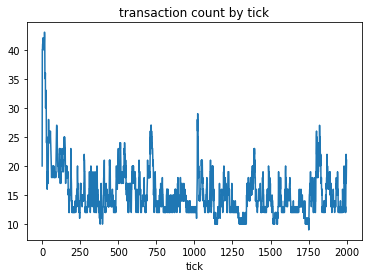

In [12]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

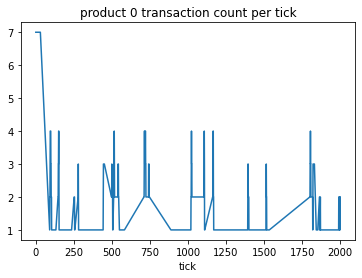

In [13]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

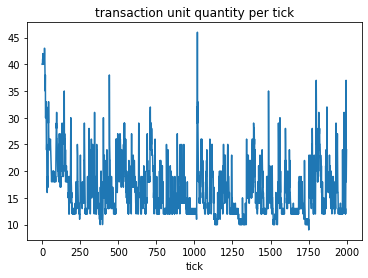

In [14]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

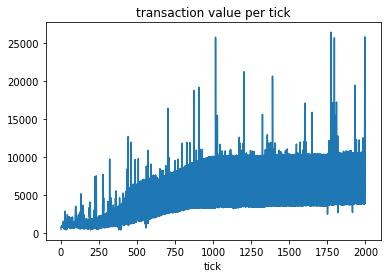

In [15]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

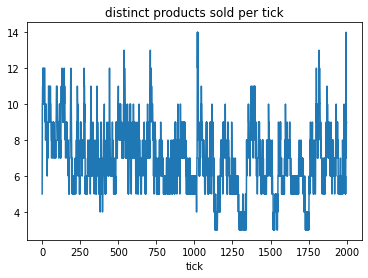

In [16]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

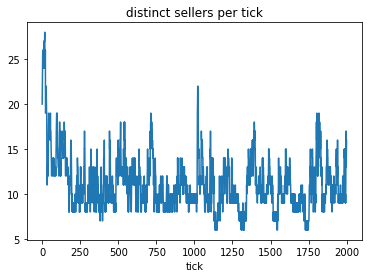

In [17]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

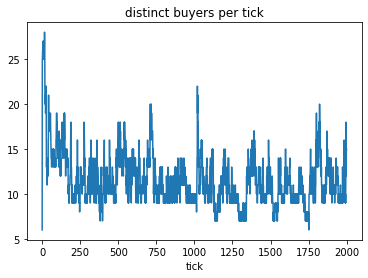

In [18]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [19]:
transaction_df["seller"].nunique()

84

In [20]:
transaction_df["buyer"].nunique()

71

In [21]:
transaction_df["product"].nunique()

22

<AxesSubplot:>

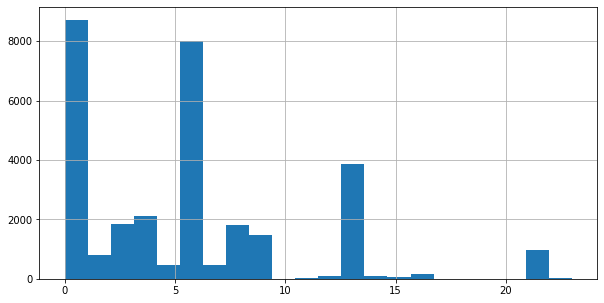

In [22]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

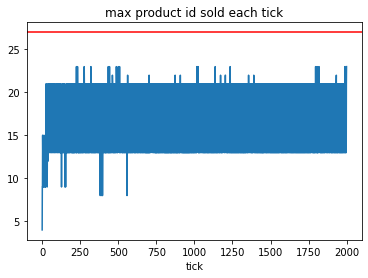

In [23]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [24]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

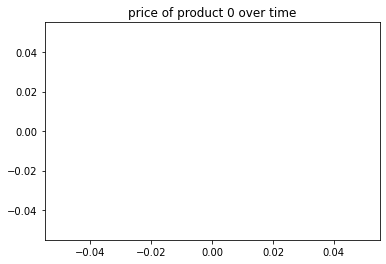

In [25]:
transaction_df[transaction_df["seller"] == 0]["price"].plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 2 over time')

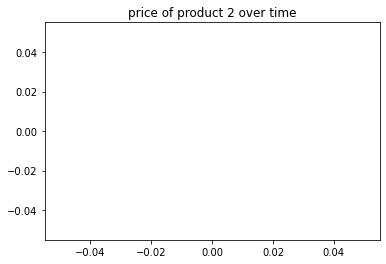

In [26]:
transaction_df[transaction_df["seller"] == 2]["price"].plot()
plt.title("price of product 2 over time")

Text(0.5, 1.0, 'price of product 6 over time')

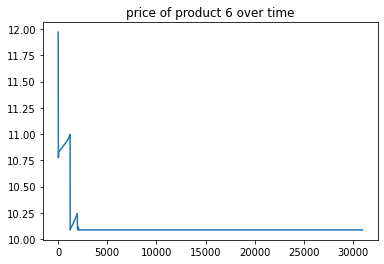

In [27]:
transaction_df[transaction_df["seller"] == 6]["price"].plot()
plt.title("price of product 6 over time")

<AxesSubplot:>

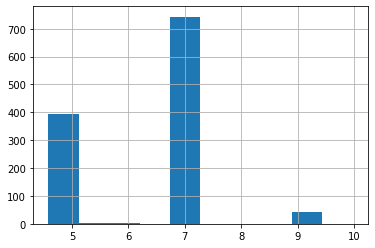

In [28]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

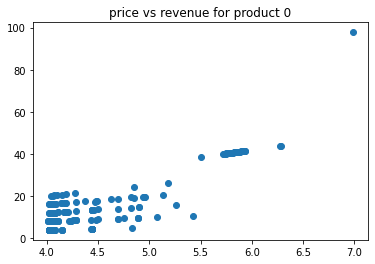

In [29]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

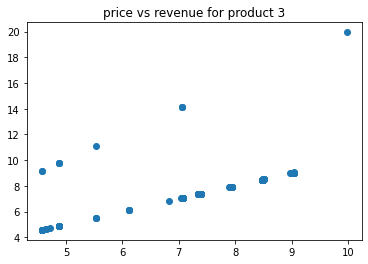

In [30]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [31]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,seller,buyer,product,amount,price,value


## Transaction Graph

In [32]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,0,5,86.0
1,0,31,80.0
2,0,52,5.0
3,0,68,5.0
4,0,92,150.0
...,...,...,...
462,97,72,6.0
463,97,78,14.0
464,97,84,157.0
465,97,85,4.0


In [33]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [34]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [35]:
G = nx.relabel_nodes(G, labels)

In [36]:
nx.is_directed_acyclic_graph(G)

True

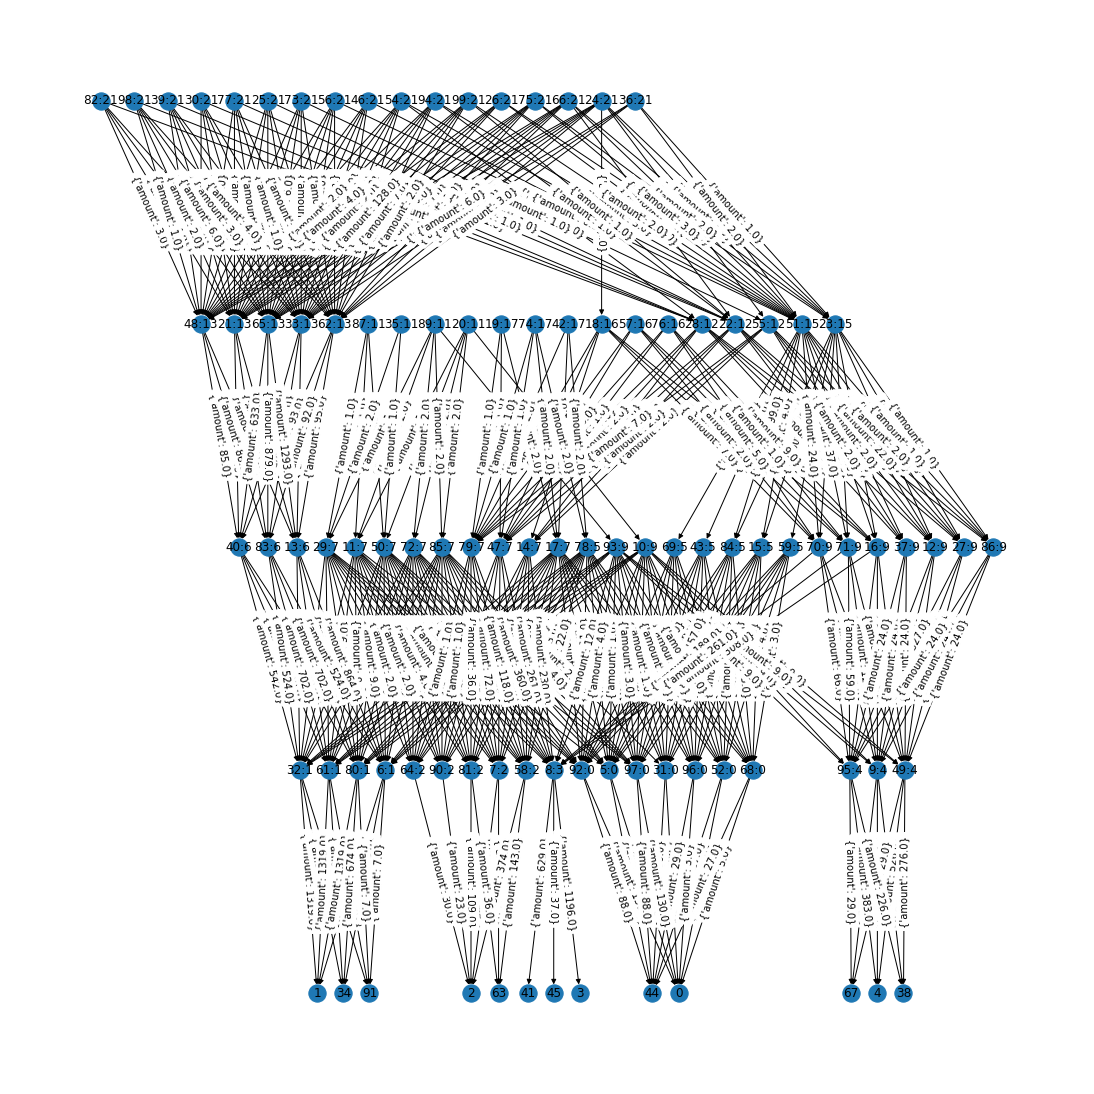

In [37]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

# Balance

In [38]:
balance_df = econ_sim.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [39]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,3.098441e+02
1,0,5.182449e+02
2,0,7.823409e+02
3,0,4.589885e+02
4,0,8.422211e+02
...,...,...
95,0,2.350000e+03
96,0,4.500000e+02
97,0,4.500000e+02


In [40]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,1999,4.207068e+02
1,1999,1.073740e+04
2,1999,1.680164e+03
3,1999,3.148738e+03
4,1999,2.912353e+03
...,...,...
95,1999,1.190197e+04
96,1999,5.035597e+02
97,1999,5.942667e+02


<AxesSubplot:xlabel='tick'>

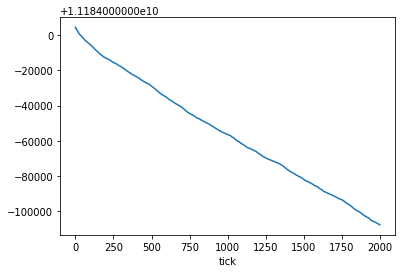

In [41]:
balance_df.groupby("tick")["balance"].sum().plot()

In [42]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].sparse.to_dense().describe()

count    1.000000e+02
mean     1.118400e+08
std      3.619714e+08
min      3.098441e+02
25%      1.250000e+03
50%      2.960000e+04
75%      1.006150e+06
max      1.409257e+09
Name: balance, dtype: float64

In [43]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].sparse.to_dense().describe()

count    1.000000e+02
mean     1.118389e+08
std      3.619226e+08
min      3.098441e+02
25%      3.105235e+03
50%      7.890361e+04
75%      1.059025e+06
max      1.409205e+09
Name: balance, dtype: float64

In [44]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

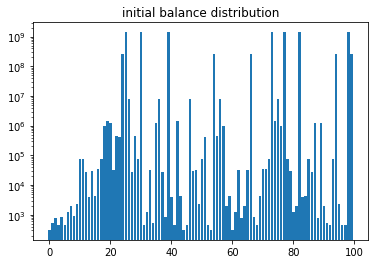

In [45]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

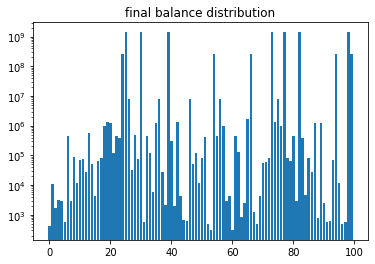

In [46]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [47]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0        110.862730
1      10219.152424
2        897.823067
3       2689.749964
4       2070.131977
          ...      
95      9551.969040
96        53.559691
97       144.266694
98    -61914.862685
99   -900935.234669
Name: balance, Length: 100, dtype: Sparse[float64, 0.0]

In [48]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0     4.207068e+02
1     1.073740e+04
2     1.680164e+03
3     3.148738e+03
4     2.912353e+03
          ...     
95    1.190197e+04
96    5.035597e+02
97    5.942667e+02
98    1.409195e+09
99    2.519877e+08
Name: balance, Length: 100, dtype: Sparse[float64, 0]

In [49]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
199900,0,1999,4.207068e+02
199901,1,1999,1.073740e+04
199902,2,1999,1.680164e+03
199903,3,1999,3.148738e+03
199904,4,1999,2.912353e+03
199905,5,1999,5.518795e+02
199906,6,1999,4.575450e+05
199907,7,1999,2.871724e+03
199908,8,1999,9.026035e+04
199909,9,1999,1.166159e+04


<AxesSubplot:>

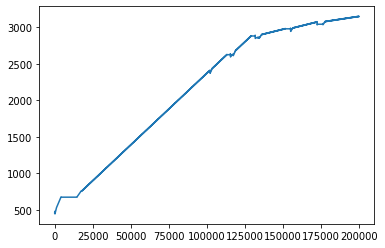

In [50]:
balance_df[balance_df["agent"] == 3]["balance"].plot()

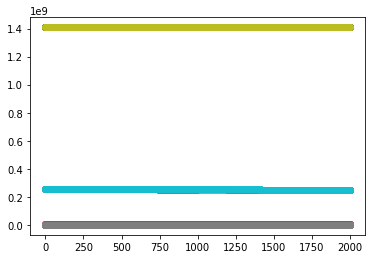

In [51]:
for agent in balance_df["agent"].unique():
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [52]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,1.357802
1,20.718771
2,2.147611
3,6.860169
4,3.457944
...,...
95,5.064668
96,1.119022
97,1.320593


# Inventory

In [53]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = econ_sim.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

## Last Tick Inventory

In [54]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,17,18,19,20,21,22,23,24,25,26
199900,0,1999,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199901,1,1999,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199902,2,1999,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199903,3,1999,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199904,4,1999,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,95,1999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,96,1999,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,97,1999,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,98,1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.0,1.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [55]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [56]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [57]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [58]:
agent_id = 25
inv_s = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent").loc[agent_id].drop("tick")
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,0.0,NaN
9,0.0,0.0,0.0,0.0,NaN


In [59]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == balance_df["tick"].max())]

,agent,tick,balance
199925,25,1999,1.409202e+09


In [60]:
buy_budget_df[(buy_budget_df["tick"] == buy_budget_df["tick"].max()) & (buy_budget_df["agent"] == agent_id)].T

,199925
agent,2.500000e+01
tick,1.999000e+03
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00


In [61]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].sparse.to_dense().describe()

count    2000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: 25, dtype: float64

# Buy and Sell Prices

In [62]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     4.015593e+00
1     8.175510e+00
2     1.176591e+01
3     4.101151e+00
4     1.077789e+01
5     4.024453e+00
6     6.924831e+01
7     1.177264e+01
8     7.208315e+00
9     1.088756e+01
10    9.572828e+02
11    1.510196e+03
12    6.562844e+01
13    7.557700e+02
14    9.227793e+02
15    1.619794e+01
16    9.340004e+01
17    3.679083e+03
18    2.012250e+04
19    3.425399e+04
20    2.546304e+04
21    4.452710e+03
22    7.607056e+03
23    9.859705e+02
24    6.602945e+06
25    4.427927e+07
26    3.481959e+05
dtype: float64

## Market Analysis for one Good

In [63]:
product_id = 21
min_ticks = 0
max_ticks = np.inf

df1 = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))].groupby("tick")[product_id].min().sparse.to_dense().to_frame().reset_index()
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks, max_ticks))].groupby("tick")[product_id].min().sparse.to_dense().to_frame().reset_index()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id].sparse.to_dense()
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id].sparse.to_dense()

buyer_df = buy_budget_df[buy_budget_df[product_id] > 0][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


2.0


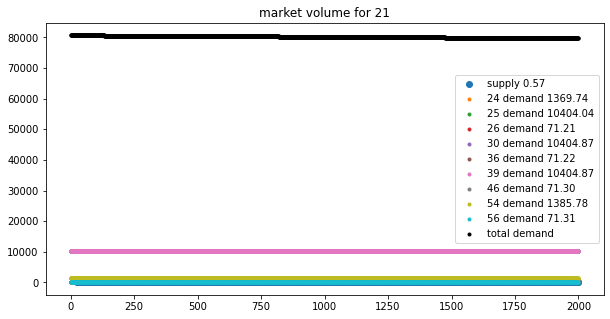

In [64]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

Text(0.5, 1.0, 'price chart for 21')

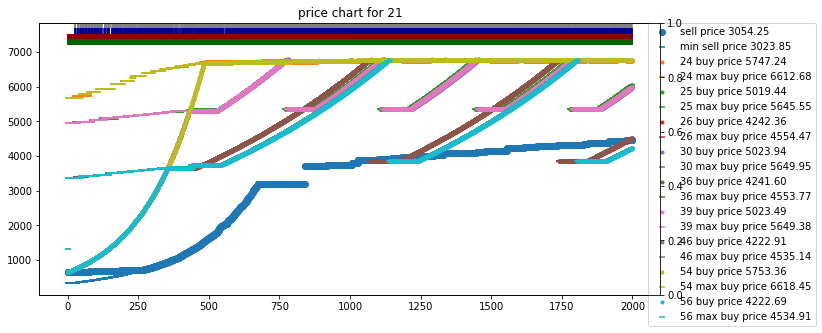

In [65]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1["tick"], df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(dfms["tick"], dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
ax2.vlines((buyer_df.groupby("tick")["units"].sum() > 0).index, ymin=0.94, ymax=0.96, color="darkred")
ax2.vlines(df1[(df2.groupby("tick")[product_id].max() - df1[product_id])>0].index, ymin=0.92, ymax=0.94, color="darkgreen")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



(0.0, 1479331926.9859915)

<Figure size 432x288 with 0 Axes>

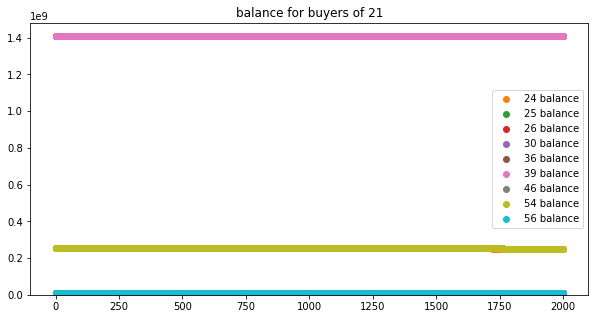

In [66]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [67]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["amount"].sum()

buyer
21     64.0
33     64.0
48     64.0
62     70.0
65    700.0
Name: amount, dtype: float64

In [68]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
21,64.0,413.890625,299.401526,28.0,213.5,376.0,548.5,1734.0
33,64.0,427.703125,340.682027,36.0,215.5,376.0,545.5,1978.0
48,64.0,402.140625,283.919107,26.0,207.5,370.0,537.5,1650.0
62,70.0,439.600000,321.643353,27.0,216.5,400.0,587.5,1845.0
65,696.0,1253.735632,459.297492,37.0,917.5,1275.5,1633.5,1998.0


In [69]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
21,64.0,2831.525227,1596.829626,703.780959,1285.044603,2557.525435,4370.680924,5564.568304
33,64.0,2838.511849,1611.920470,719.104147,1294.377244,2559.150122,4362.216299,5745.504268
48,64.0,2781.968945,1577.522442,700.044744,1257.598796,2486.710543,4329.091304,5539.609290
62,70.0,2959.316280,1666.442086,701.908193,1300.521529,2856.846966,4538.493668,5616.630018
65,696.0,6204.038236,1253.604441,721.062893,6268.042143,6757.274825,6763.713757,6785.254177


### Buy/Sell Price Investigation

In [70]:
df1[product_id].describe()

count    2000.000000
mean     3054.246933
std      1386.568196
min       654.710000
25%      1629.128396
50%      3735.856734
75%      4151.325569
max      4452.710412
Name: 21, dtype: float64

In [71]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
24,2000.0,5747.242773,1949.079891,658.0,6703.889779,6738.779301,6747.966407,6781.773787
25,2000.0,5019.439516,1633.378138,658.0,5312.261215,5421.856110,5991.227235,6783.615435
26,2000.0,4242.364892,1475.078961,658.0,3826.579521,4243.591471,5281.342782,6786.496309
30,2000.0,5023.941296,1637.388410,658.0,5300.801659,5420.151861,5995.055202,6802.478924
36,2000.0,4241.603622,1473.628618,658.0,3829.886264,4245.386490,5278.432200,6778.796496
39,2000.0,5023.488909,1636.337710,658.0,5302.744016,5421.051147,5990.660170,6792.029337
46,2000.0,4222.910200,1476.313500,658.0,3731.545266,4153.258836,5279.766893,6776.929527
54,2000.0,5753.359988,1951.841399,658.0,6677.901277,6746.975872,6769.252080,6799.013222
56,2000.0,4222.687579,1475.718183,658.0,3750.705639,4149.673034,5279.691546,6777.770342


In [72]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

2306.7549456475845

In [73]:
(df2.groupby("tick")[product_id].max() - df1.set_index("tick")[product_id]).describe()

count    2000.000000
mean     2705.931506
std      1061.333603
min         0.000000
25%      2421.564902
50%      2690.816302
75%      3045.203126
max      5160.910468
Name: 21, dtype: float64

In [74]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

2306.7549456475845

In [75]:
(dfmb.groupby("tick")[product_id].max() - dfms.set_index("tick")[product_id]).describe()

count    2000.000000
mean     3603.072677
std      1218.013422
min       993.006604
25%      2618.974462
50%      3015.484424
75%      5067.982470
max      5673.275382
Name: 21, dtype: float64

In [76]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
21,328.000000,545.414146,658.000000,327.802181,330.000000
121,328.000000,658.000000,654.710000,328.000000,326.710000
221,329.640000,658.000000,654.710000,328.000000,325.070000
321,331.288200,658.000000,654.710000,328.000000,323.421800
421,332.944641,658.000000,654.710000,328.000000,321.765359
...,...,...,...,...,...
199521,5560.524048,5560.524048,4708.492126,4708.492126,-852.031923
199621,5560.524048,5560.524048,4708.492126,4708.492126,-852.031923
199721,5560.524048,5560.524048,4708.492126,4708.492126,-852.031923
199821,5560.524048,5560.524048,4708.492126,4708.492126,-852.031923


## Larger Scale Market Analysis

In [77]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

In [78]:
((demand_units_df.groupby("tick").sum()) ** 2).mean() - (demand_units_df.groupby("tick").sum()).mean()

0     1.883000e+00
1     1.201600e+01
2     9.790000e-01
3     1.000000e-02
4     2.161000e+00
5     4.511700e+02
6     1.737030e+04
7     6.180761e+03
8     7.719916e+03
9     6.277030e+02
10    4.673360e+02
11    2.204680e+03
12    3.028180e+02
13    1.035960e+03
14    1.384416e+04
15    2.014900e+01
16    2.133740e+03
17    2.120576e+03
18    5.727731e+04
19    4.950374e+06
20    1.575492e+06
21    6.426456e+09
22    2.307059e+07
23    3.642777e+05
24    0.000000e+00
25    0.000000e+00
26    0.000000e+00
dtype: float64

In [79]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean()
demand_units_mean - supply_units_mean

0          -44.5240
1          -22.0075
2          -33.7095
3          -28.6260
4          -31.2120
5          -20.2330
6          126.8230
7           50.6115
8           78.6380
9            6.5845
10          22.0375
11          47.1285
12          -3.3685
13          30.6975
14         117.6400
15         -21.9435
16          40.1250
17          46.4730
18         239.7665
19        2224.8870
20        1255.3720
21       80144.5710
22        4802.4200
23         598.0830
24           0.0000
25           0.0000
26           0.0000
agent           NaN
dtype: float64

In [80]:
#(demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean()
(((demand_units_df.groupby("tick").sum()) ** 2).mean() - demand_units_mean)/demand_units_mean

0         2.872616
1         3.004000
2         1.530884
3         0.010741
4         1.864538
5        23.082472
6       132.779149
7        79.985519
8        96.476640
9        32.045283
10       21.133994
11       46.770262
12       19.906521
13       31.751130
14      117.637413
15        6.255511
16       50.422166
17       45.625862
18      238.887361
19     2225.000000
20     1255.000000
21    80185.233051
22     4803.887884
23      603.284108
24             NaN
25             NaN
26             NaN
dtype: float64

In [81]:
#(supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()
(((supply_units_df.groupby("tick").sum()) ** 2).mean() - supply_units_mean)/supply_units_mean

agent    6632.333333
0        1187.793999
1         879.198270
2        1193.966986
3         988.028961
4        1104.128757
5         575.652857
6          98.950475
7         547.620171
8         171.362550
9         470.983889
10         44.264901
11          0.200000
12        488.698420
13         80.356995
14          1.666667
15        504.647579
16        312.486659
17          0.444444
18          0.000000
19               NaN
20               NaN
21         45.522968
22         42.725806
23        440.718105
24               NaN
25               NaN
26               NaN
dtype: float64

# Profit Analysis

In [82]:
revenue = transaction_df.groupby("seller")["value"].sum()
costs = transaction_df.groupby("buyer")["value"].sum()

In [83]:
costs

buyer
0      1990.160248
1     53353.144366
2      9016.299179
3      7594.726714
4     17827.403107
          ...     
92     1201.459684
93     1044.408973
95    17708.897392
96      243.026712
97     1114.498280
Name: value, Length: 71, dtype: float64

In [84]:
revenue

seller
5        669.323212
6      20211.635543
7       2590.334525
8      11921.823971
9      10210.406106
          ...      
95      8156.928352
96       189.467021
97       970.231585
98     61914.862685
99    900935.234669
Name: value, Length: 84, dtype: float64

In [95]:
(revenue-costs)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
         ...     
95   -9551.969040
96     -53.559691
97    -144.266694
98            NaN
99            NaN
Name: value, Length: 97, dtype: float64

In [86]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,1999,110.862730
1,1999,10219.152424
2,1999,897.823067
3,1999,2689.749964
4,1999,2070.131977
...,...,...
95,1999,9551.969040
96,1999,53.559691
97,1999,144.266694


# Production Efficiency

In [87]:
production_efficiency_df = econ_sim.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")